In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing #カリフォルニア
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import pandas as pd
import matplotlib.pyplot as plt

import nnabla as nn
import nnabla.functions as F
import nnabla.parametric_functions as PF
import nnabla.solvers as S

%matplotlib inline

2023-02-23 15:05:16,887 [nnabla][INFO]: Initializing CPU extension...


データの確認

In [2]:
california_housing = fetch_california_housing()

train_x = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
train_y = pd.Series(california_housing.target)

train_x.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [3]:
train_y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
dtype: float64

データの導入と正規化

In [4]:
dataset = fetch_california_housing()
Y = dataset.target
X = dataset.data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
len(X_train)

18576

In [5]:
scaler = StandardScaler()
X_n_train = scaler.fit_transform(X_train)
X_n_test = scaler.fit_transform(X_test)

データイテレーターを作成する

In [6]:
def batch_iterator(data, label, batch_size):
    n_samples = data.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        label_2d = label[batch_idx].reshape((batch_size, 1))
        yield data[batch_idx], label_2d

2層のニューラルネットワーク

In [7]:
nn.clear_parameters()
batch_size = 64
def Create_double_network():
    x = nn.Variable([batch_size, X_n_train.shape[1]])
    with nn.parameter_scope("tanh"):
        h = F.tanh(PF.affine(x, 32))
    with nn.parameter_scope("affine1"):
        y = PF.affine(h, 1)
    return x, y

In [8]:
x, y = Create_double_network()
t = nn.Variable([batch_size, 1])
loss = F.mean(F.squared_error(y, t))

In [9]:
batches = batch_iterator(X_n_train, Y_train, batch_size)

In [10]:
def training(steps, learning_rate):
    solver = S.Sgd(learning_rate)
    solver.set_parameters(nn.get_parameters())
    for i in range(steps):
        x.d, t.d = batches.__next__()
        loss.forward()
        solver.zero_grad()  # Initialize gradients of all parameters to zero.
        loss.backward()
        solver.weight_decay(1e-5)  # Applying weight decay as an regularization
        solver.update()
        if i % 10 == 0:  # Print for each 10 iterations
            print(i, loss.d)


# Training
training(250, 1e-2)

0 6.362567
10 2.2211943
20 2.0093443
30 0.92760277
40 0.69544774
50 0.6659171
60 0.8557851
70 0.5916698
80 0.82645166
90 0.40587372
100 0.59718525
110 0.7468871
120 0.59670985
130 0.36298394
140 0.44367075
150 0.52745605
160 0.4539892
170 0.54055196
180 0.44276172
190 0.29446718
200 0.43175763
210 0.37675738
220 0.3179521
230 0.63225526
240 0.6059755


In [11]:
batches_test = batch_iterator(X_n_test, Y_test, batch_size)
x.d, t.d = batches_test.__next__()
y.forward()
print(mean_absolute_error(t.d, y.d))

0.6057979136225581


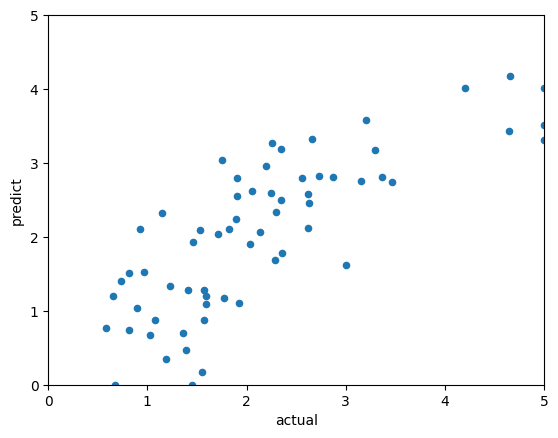

In [12]:
result = pd.DataFrame({
    "predict": np.reshape(y.d, (-1,)),
    "actual": np.reshape(t.d, (-1,))
})
limit = np.max(t.d)

result.plot.scatter(x="actual", y="predict", xlim=(0, limit), ylim=(0, limit))
plt.show()

XAIの導入